In [1]:
%matplotlib inline
import numpy as np
import os
import time
import h5py
import keras
import pandas as pd
import math
import joblib
import json
import scipy
import matplotlib.pyplot as plt
from scipy.stats import logistic

from IPython.display import display

from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

from keras.layers import (Input, Dense, Lambda, Flatten, Reshape, BatchNormalization, 
                          Activation, Dropout, Conv2D, Conv2DTranspose, LocallyConnected2D,
                          Concatenate, Add, Multiply)
from keras.engine import InputSpec
from keras.losses import sparse_categorical_crossentropy
from keras.optimizers import RMSprop, Adam, SGD
from keras.models import Model
from keras.utils import to_categorical
from keras.regularizers import l2
from keras import metrics
from keras import backend as K
from keras_tqdm import TQDMNotebookCallback
from keras.datasets import cifar10

import tensorflow as tf

/home/brian/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Parameters

In [2]:
img_rows, img_cols, img_chns = 2, 2, 3
original_img_size = (img_rows, img_cols, img_chns)
num_samples = 1000

batch_size = int(os.environ.get('BATCH_SIZE', 1))
epochs = int(os.environ.get('EPOCHS', 1000))
activation = os.environ.get('ACTIVATION', 'relu')
learning_rate = float(os.environ.get('LEARNING_RATE', 0.001))
resnet_depth = int(os.environ.get('RESNET_DEPTH', 1))
n_components = int(os.environ.get('MIXTURE_COMPONENTS', 2))

# Generate a dataset based on mixtures of logistic

Scaling and shifting a logistic: http://www.math.wm.edu/~leemis/chart/UDR/PDFs/LogisticS.pdf


X ~ Logistic(m, s)

Y = cX

then:

Y ~ Logistic(m, s*c)

In [3]:
np.random.seed(127)

# logistic std deviation of 1 pixel level
unit_s = 1 / math.pi * math.sqrt(3)

def train_data_simple(num_samples):
    # Each pixel is a independent single logstic
    X_train = np.zeros((num_samples, img_rows, img_cols, img_chns))
    
    # Set the distribution values to fixed values so we can tell the difference
    m = np.array([
        [
            [[10.,  250.],  [10, 250.],  [10, 250.]],
            [[10.,  250.],  [10., 10. ], [10., 10.]]
        ], 
        [
            [[10.,  100.],  [10., 250. ], [10., 10.]], 
            [[10.,  10.],  [10., 10. ], [10., 250.]]
        ], 
    ])
    s = 10 * unit_s * np.ones((img_rows, img_cols, img_chns, n_components))
    w = np.ones((img_rows, img_cols, img_chns, n_components))
    w = w / w.sum(axis=3)[:, :, :, np.newaxis]
    
    #m = np.random.normal(127.5, 40, (img_rows, img_cols, img_chns, n_components))
    #s = np.random.uniform(1 * unit_s, 40 * unit_s, (img_rows, img_cols, img_chns, n_components))
    #
    ## Each row has same mxiture weight
    #w = np.random.randint(1, 10, (img_rows, img_cols, img_chns, n_components))
    #w = w / w.sum(axis=3)[:, :, :, np.newaxis]
    
    for n in range(num_samples):
        for i in range(img_rows):
            for j in range(img_cols):
                for k in range(img_chns):
                    pixels = []
                    for c in range(n_components):
                        pixels.append(np.random.logistic(m[i, j, k, c], s[i, j, k, c], 1))
                    index = np.argmax(np.random.multinomial(1, w[i, j, k])) 
                    X_train[n, i, j, k] = max(min(int(pixels[index]), 255), 0)
                
    print('Logistic m:')
    print((m - 127.5) / 127.5)
    print('Logistic s')
    print(np.log(127.5 / s))
    print('Mixture w')
    print(w)
    return X_train, (m, s, w)

X_train, params = train_data_simple(num_samples)
X_train = (X_train - 127.5) / 127.5
print(X_train.shape)
#print(params)

Logistic m:
[[[[-0.92156863  0.96078431]
   [-0.92156863  0.96078431]
   [-0.92156863  0.96078431]]

  [[-0.92156863  0.96078431]
   [-0.92156863 -0.92156863]
   [-0.92156863 -0.92156863]]]


 [[[-0.92156863 -0.21568627]
   [-0.92156863  0.96078431]
   [-0.92156863 -0.92156863]]

  [[-0.92156863 -0.92156863]
   [-0.92156863 -0.92156863]
   [-0.92156863  0.96078431]]]]
Logistic s
[[[[3.14095501 3.14095501]
   [3.14095501 3.14095501]
   [3.14095501 3.14095501]]

  [[3.14095501 3.14095501]
   [3.14095501 3.14095501]
   [3.14095501 3.14095501]]]


 [[[3.14095501 3.14095501]
   [3.14095501 3.14095501]
   [3.14095501 3.14095501]]

  [[3.14095501 3.14095501]
   [3.14095501 3.14095501]
   [3.14095501 3.14095501]]]]
Mixture w
[[[[0.5 0.5]
   [0.5 0.5]
   [0.5 0.5]]

  [[0.5 0.5]
   [0.5 0.5]
   [0.5 0.5]]]


 [[[0.5 0.5]
   [0.5 0.5]
   [0.5 0.5]]

  [[0.5 0.5]
   [0.5 0.5]
   [0.5 0.5]]]]
(1000, 2, 2, 3)


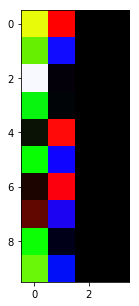

In [4]:
n = min(num_samples, 5)
figure = np.zeros((img_rows * n, img_cols * 2, img_chns)).astype(int)
for i in range(n):
    orig_img = (X_train[i] * 127.5 + 127.5).astype(int)
    dy = img_rows * i
    figure[dy:dy + img_rows, :img_cols] = orig_img
    
    # Digitize
    #img = orig_img #.astype(float) / 255
    #figure[dy:dy + img_rows, img_cols:2 * img_cols] = img

plt.figure(figsize=(n * 4, 5))
plt.imshow(figure)
plt.show()

# Pixel CNN Helpers

# Model

In [5]:
if K.image_data_format() == 'channels_last':
    bn_axis = 3
else:
    bn_axis = 1

In [16]:
def pixelcnn_loss(target, output):
    output_m = output[:, :, :, :3*n_components]
    output_invs = output[:, :, :, 3*n_components:6*n_components]
    output_weights = output[:, :, :, 6*(n_components):]
    x = K.reshape(target, (-1, img_rows, img_cols, img_chns))
    
    # Repeat the target to match the number of mixture component shapes
    slices = []
    for c in range(img_chns):
        slices += [x[:, :, :, c:c+1]] * n_components
    x = K.concatenate(slices, axis=-1)
    
    x_decoded_m = output_m
    x_decoded_invs = output_invs
    x_weights = output_weights
   
    offset = 1. / 127.5 / 2.
    centered_mean = x - x_decoded_m

    cdfminus_arg = (centered_mean - offset) * K.exp(x_decoded_invs)
    cdfplus_arg = (centered_mean + offset) * K.exp(x_decoded_invs)
                   
    cdfminus_safe = K.sigmoid(cdfminus_arg)
    cdfplus_safe = K.sigmoid(cdfplus_arg)
  
    # ln (sigmoid(x)) = x - ln(e^x + 1) = x - softplus(x)
    log_cdfplus = cdfplus_arg - K.tf.nn.softplus(cdfplus_arg)
    log_1minus_cdf = -K.tf.nn.softplus(cdfminus_arg)
    log_ll = K.tf.where(x <= 0.001, log_cdfplus,
                        K.tf.where(x >= 0.999, log_1minus_cdf,
                                   K.log(K.maximum(cdfplus_safe - cdfminus_safe, 1e-10))))
    
    ## x_weights * [sigma(x+0.5...) - sigma(x-0.5 ...) ]
    ## = log x_weights + log (...)
    pre_result = K.log(x_weights) + log_ll
    
    result = []
    for chn in range(img_chns):
        chn_result = pre_result[:, :, :, chn*n_components:(chn+1)*n_components]
        v = K.logsumexp(chn_result, axis=-1)
        result.append(v)
    result = K.batch_flatten(K.stack(result, axis=-1))
    
    return -K.sum(result, axis=-1)   

In [27]:
# Work around Keras/tensorboard bug: https://github.com/keras-team/keras/issues/10074
K.clear_session()

main_input = Input(shape=original_img_size, name='main_input')

ms = []
invss = []
weights = []
for channel in range(img_chns):
    x = Lambda(lambda x: x * 0.)(main_input)
    x = Flatten()(x)
    decoder_out_m_ = Dense(img_rows * img_cols * n_components, name='x_m' + str(channel),
                           bias_initializer='glorot_uniform')(x)
    decoder_out_m_ = Lambda(lambda x: x + 0.5)(decoder_out_m_)
    decoder_out_m = Reshape((img_rows, img_cols, n_components))(decoder_out_m_)
    ms.append(decoder_out_m)
    
    decoder_out_invs_ = Dense(img_rows * img_cols * n_components, name='x_s' + str(channel),
                              activation='sigmoid', bias_initializer='glorot_uniform')(x)
    decoder_out_invs = Lambda(lambda x: 5. * x + 2.)(decoder_out_invs_)
    decoder_out_invs = Reshape((img_rows, img_cols, n_components))(decoder_out_invs)
    
    invss.append(decoder_out_invs)
   
    x_reshape = Reshape((img_rows, img_cols, img_chns))(x)
    mixture_weights = LocallyConnected2D(name='weights' + str(channel),
                                         filters=n_components, kernel_size=1, strides=1,
                                         activation='softmax',
                                         bias_initializer='glorot_uniform')(x_reshape)
    weights.append(mixture_weights)

out_m = Concatenate()(ms)
out_invs = Concatenate()(invss)
out_weights = Concatenate()(weights)
main_output = Concatenate()([out_m, out_invs, out_weights])

In [28]:
print("Building model...")
#optimizer = RMSprop(lr=0.001)


optimizer = SGD(lr=0.001)
model = Model(inputs=main_input, outputs=main_output)
model.compile(optimizer=optimizer, loss=pixelcnn_loss)
model.summary()

Building model...
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 2, 2, 3)      0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 2, 2, 3)      0           main_input[0][0]                 
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 2, 2, 3)      0           main_input[0][0]                 
__________________________________________________________________________________________________
lambda_7 (Lambda)               (None, 2, 2, 3)      0           main_input[0][0]                 
___________________________________________________________________________________________

In [29]:
start = time.time()


early_stopping = keras.callbacks.EarlyStopping('loss', min_delta=1.0, patience=5)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, min_lr=0.0001)
tensorboard = keras.callbacks.TensorBoard(log_dir='./logs_test_loss_mixture/base', histogram_freq=1, batch_size=1, write_graph=True, 
                                          write_grads=True, write_images=True, update_freq='batch')

history = model.fit(
    X_train, X_train,
    batch_size=batch_size,
    #epochs=epochs,
    epochs=40,
    #callbacks=[TQDMNotebookCallback(), tensorboard, early_stopping, reduce_lr],
    callbacks=[TQDMNotebookCallback(), early_stopping, reduce_lr],
    #validation_data=(X_train, X_train),
    verbose=0
)

done = time.time()
elapsed = done - start
print("Elapsed: ", elapsed)

Elapsed:  87.09346437454224


,loss,lr
count,13.000000,13.000
mean,40.662782,0.001
std,7.063635,0.000
min,36.543083,0.001
0%,36.543083,0.001
25%,36.840822,0.001
50%,38.666149,0.001
75%,40.847879,0.001
95%,51.410497,0.001
99%,60.592581,0.001


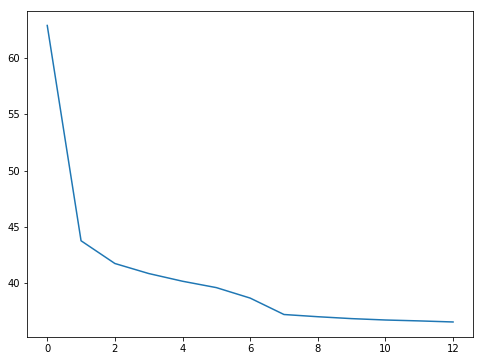

In [30]:
df = pd.DataFrame(history.history)
display(df.describe(percentiles=[0.25 * i for i in range(4)] + [0.95, 0.99]))
df['loss'].plot(figsize=(8, 6))

In [31]:
lossvals = model.evaluate(X_train, X_train)
print(lossvals)

1000/1000 [==============================] - 0s 268us/step
36.396010467529294


# Generate Some Images

In [32]:
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

def compute_pvals(m, invs):
    pvals = []
    for i in range(256):
        if i == 0:
            pval = logistic.cdf((0.5 - 127.5) / 127.5, loc=m, scale=1. / np.exp(invs))
        elif i == 255:
            pval = 1. - logistic.cdf((254.5 - 127.5) / 127.5, loc=m, scale=1. / np.exp(invs))
        else:
            pval = (logistic.cdf((i + 0.5 - 127.5) / 127.5, loc=m, scale=1. / np.exp(invs))
                    - logistic.cdf((i - 0.5 - 127.5) / 127.5, loc=m, scale=1. / np.exp(invs)))
        pvals.append(pval)
    
    return pvals

def compute_mixture(ms, invs, weights):
    components = []
    for i in range(n_components):
        components.append(weights[i] * np.array(compute_pvals(ms[i], invs[i])))
    return np.sum(components, axis=0)

(2, 2, 3)
==== 0 0 0
 m:  [0.5091925 0.6302173]
 param_m:  [-0.92156863  0.96078431]
 E[m]:  0.51378554
 invs:  [2.0118694 5.2962723]
 param_invs:  [3.14095501 3.14095501]
 weights:  [0.96204895 0.03795102]
 param_weight:  [0.5 0.5]
 pvals:  172    0.010049
173    0.010364
174    0.010675
175    0.010981
176    0.011280
177    0.011572
178    0.011855
179    0.012127
180    0.012387
181    0.012633
182    0.012865
183    0.013080
184    0.013278
185    0.013456
186    0.013615
187    0.013753
188    0.013869
189    0.013963
190    0.014033
191    0.014079
192    0.014102
193    0.014100
194    0.014074
195    0.014024
196    0.013950
197    0.013853
198    0.013733
199    0.013592
200    0.013430
201    0.013249
202    0.013054
203    0.012863
204    0.012752
205    0.013080
206    0.015230
207    0.021601
208    0.025504
209    0.018665
210    0.013017
211    0.011094
212    0.010414
213    0.010021
255    0.024596
dtype: float64
 pixel_val:  139
==== 0 0 1
 m:  [0.13001338 0.3695234 

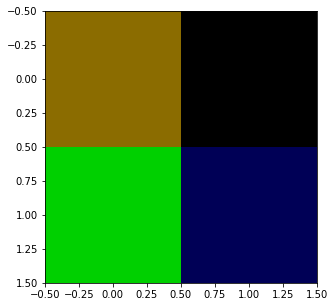

Orig: 


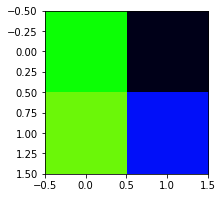

Elapsed:  1.695288896560669


In [33]:
debug = True

def gen_image(model, num_samples=batch_size):
    x_sample = np.zeros((num_samples, img_rows, img_cols, img_chns))
    
    # Iteratively generate each conditional pixel P(x_i | x_{1,..,i-1})
    for i in range(img_rows):
        for j in range(img_cols):
            for k in range(img_chns):
                x_out = model.predict(x_sample, num_samples)
                for n in range(num_samples):
                    offset = k * n_components
                    x_ms = x_out[n, i, j, offset:offset + n_components]
                    offset = n_components * img_chns + k * n_components
                    x_invs = x_out[n, i, j, offset:offset + n_components]
                    offset = 2 * n_components * img_chns + k * n_components
                    weights = x_out[n, i, j, offset:offset + n_components]
                    pvals = compute_mixture(x_ms, x_invs, weights)
                    pvals /= (np.sum(pvals) + 1e-5)
                    pixel_val = np.argmax(np.random.multinomial(1, pvals))
                    x_sample[n, i, j, k] = pixel_val / 255.
                    if 0 <= i <= 1 and 0 <= j <= 1 and debug:
                        print("====", i, j, k)
                        print(" m: ", x_ms)
                        print(" param_m: ", (params[0][i, j, k] - 127.5) / 127.5)
                        print(" E[m]: ", (x_ms * weights).sum())
                        print(" invs: ", x_invs)
                        print(" param_invs: ", np.log(127.5 / params[1][i, j, k]))
                        print(" weights: ", weights)
                        print(" param_weight: ", params[2][i, j, k])
                        s = pd.Series(pvals)
                        print(" pvals: ", s[s>1e-2])
                        print(" pixel_val: ", pixel_val)
                        #print(" x_out[n, i, j, :]: ", x_out[n, i, j, :])
                        #print(" x_out: ", x_out)
                        #print(" sample_val: ", x_sample[n, i, j, k])
                        #assert False
        if debug:
            print("row", i)
                
    return x_sample


start = time.time()

n = 1 if debug else 10
figure = np.zeros((img_rows * ((n - 1) // 10 + 1), img_cols * n, img_chns))
print(figure.shape)
for i in range(n):
    samples = gen_image(model)
    for j in range(batch_size):
        img = samples[j] 
        d_x = ((i * batch_size + j) // 10) * img_rows
        d_y = ((i * batch_size + j) % 10) * img_cols
        figure[d_x:d_x + img_rows, d_y:d_y + img_cols, :] = img
        
print("Generated: ", elapsed)
plt.figure(figsize=(5, 5))
plt.imshow(figure)
plt.show()

print("Orig: ")
plt.figure(figsize=(3, 3))
plt.imshow(orig_img)
plt.show()

done = time.time()
elapsed = done - start
print("Elapsed: ", elapsed)

# Validatation

Check that we were able to approximately recover the original distributions

KL Divergence(orig, gen) for (0,0,0): 5.47
KL Divergence(orig, gen) for (0,0,1): 5.47
KL Divergence(orig, gen) for (0,0,2): 3.10
KL Divergence(orig, gen) for (0,1,0): 9.08
KL Divergence(orig, gen) for (0,1,1): 6.54
KL Divergence(orig, gen) for (0,1,2): 5.73
KL Divergence(orig, gen) for (1,0,0): 79.04
KL Divergence(orig, gen) for (1,0,1): 5.48
KL Divergence(orig, gen) for (1,0,2): 5.91
KL Divergence(orig, gen) for (1,1,0): 5.90
KL Divergence(orig, gen) for (1,1,1): 6.88
KL Divergence(orig, gen) for (1,1,2): 5.43


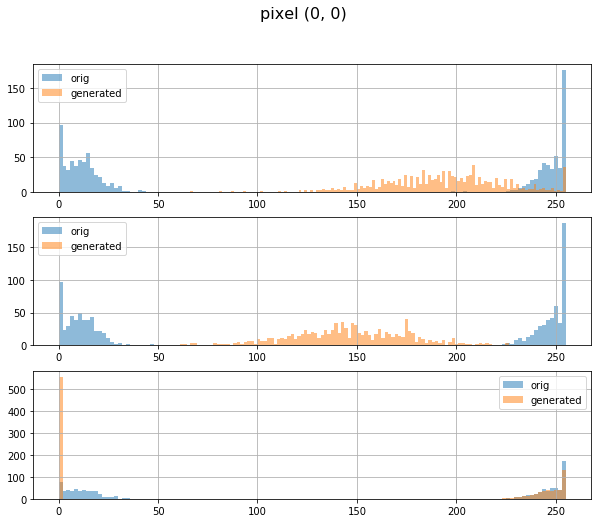

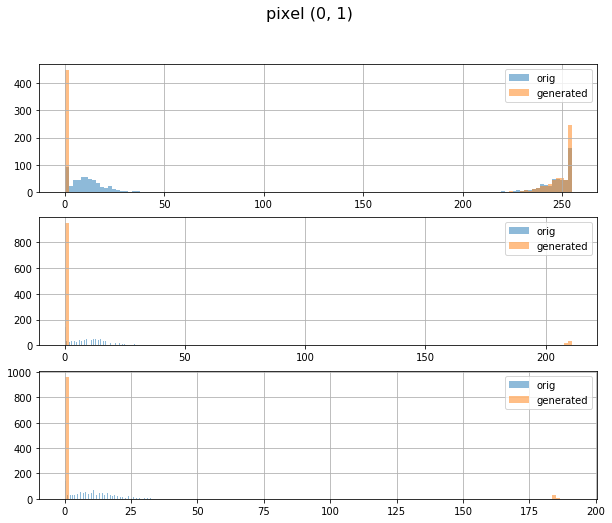

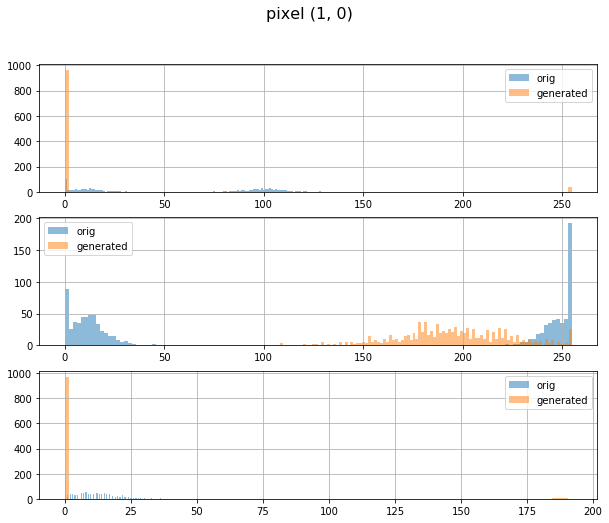

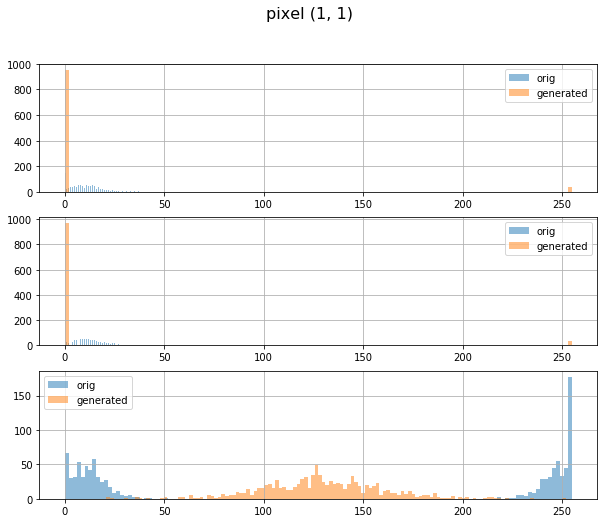

In [34]:
N = 1000

# Generated params 
x_sample = np.zeros((num_samples, img_rows, img_cols, img_chns))
x_out = model.predict(x_sample, num_samples)

for i in range(img_cols):
    for j in range(img_rows):
        fig = plt.figure(figsize=(10,8), )
        fig.suptitle("pixel (%d, %d)" % (i, j), fontsize=16)
        for k in range(img_chns):
            ax = plt.subplot(img_chns, 1, k + 1)
            
            # Orig params
            ms = (params[0][i, j, k, :] - 127.5)  / 127.5
            invss = np.log(127.5 / params[1][i, j, k, :])
            weights = params[2][i, j, k, :]
            
            pvals_orig = compute_mixture(ms, invss, weights)
            pvals_orig /= pvals_orig.sum()
            samples = pd.Series(np.random.choice(len(pvals_orig), N, p=pvals_orig))
            samples.hist(bins=128, ax=ax, alpha=0.5, label='orig')
            
            # Generated params
            offset = k * n_components
            ms = x_out[n, i, j, offset:offset + n_components]
            offset = n_components * img_chns + k * n_components
            invss = x_out[n, i, j, offset:offset + n_components]
            offset = 2 * n_components * img_chns + k * n_components
            weights = x_out[n, i, j, offset:offset + n_components]
            
            pvals_gen = compute_mixture(ms, invss, weights)
            pvals_gen /= pvals_gen.sum()
            samples = pd.Series(np.random.choice(len(pvals_gen), N, p=pvals_gen))
            samples.hist(bins=128, ax=ax, alpha=0.5, label='generated')
            
            ax.legend()
            print('KL Divergence(orig, gen) for (%d,%d,%d): %.2f' % (i, j, k, scipy.stats.entropy(pvals_orig, pvals_gen)))

# Notes



### 2019-03-07

 * It looks like my generated distributions are spreading too much mass over the range, which might be because I'm allowing the "invs" param to be small (< 1), which will naturally spread it very wide.  The model probably gets confused in these situations and finds a local minima that spreads it wide instead of using the power of the mixtures.  Maybe try to constrain it a bit more?
 
<img src="images/2019-03-07-spread.png">

 * Tried to make "invs" to be in range (2, 7), but it looks like it made the spreading worse.  It looks like these bimodal distributions aren't using the weights properly.  Maybe I need to debug my loss function?  The mixture maybe aren't being taken into account properly?

### 2019-03-03

Issues:
    
    * Wrong order of RGB slices when repeating image
    * Used old 255. value vs. 127.5
    * Added non-zero init to param values
    
Next TODO:

    * Plot histograms of 0 to 255 pixel values, somehow see that the mass is the same?
    * Maybe KL divergence?